In [1]:
import utils
import numpy as np
from matplotlib import pyplot

from sklearn import svm, decomposition
import pandas


In [2]:
# part 1 - basics, analysis on the iris dataset.
data,labels = utils.load_iris()

In [3]:
# This block just does some small initial work useful for the visualizations.
#
# a little data exploration - a couple manual histogram sets.
# a single scatterplot.
# and a mention to seaborn.

# build a dictionary useful to reference the data depending on type of flower.
flowers = np.unique(labels)
ec = {f: np.where(labels==f)[0] for f in flowers}

# choose a consistent color scheme.
mycm = pyplot.cm.Set2
palette = [mycm(j) for j in range(len(flowers))] # one color per flower
palette_map = {f:c for f,c in zip(flowers,palette)}


Text(0.5, 1.0, 'Flower distribution for variable 3')

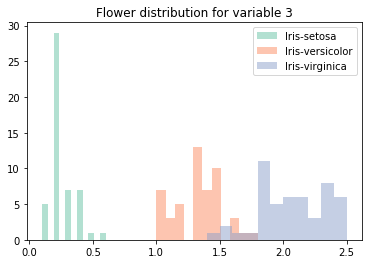

In [4]:
# Look at the data per-variable in histograms.
fig,ax = pyplot.subplots(1,1)

# loop over the flowers, picking a variable.
attr=3

for k,v in ec.items():
    ax.hist(data[v,attr], bins=11, color=palette_map[k], alpha=0.5, label=k)
    
ax.legend()
ax.set_title('Flower distribution for variable %i'%attr)

Text(0.5, 1.0, 'Flower distribution for variables [2, 3]')

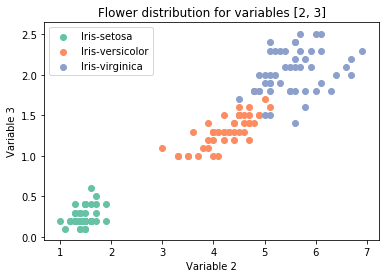

In [5]:
# Look at the data in a pair of variables as a scatter plot.
fig2,ax2 = pyplot.subplots(1,1)

attrs = [2,3]

for k,v in ec.items():
    ax2.scatter(data[v,attrs[0]], data[v,attrs[1]], color=[palette_map[k]], label=k)
    
ax2.legend()
ax2.set_xlabel('Variable %i'%attrs[0])
ax2.set_ylabel('Variable %i'%attrs[1])
ax2.set_title('Flower distribution for variables %s'%str(attrs))



Text(0.5, 1.0, 'Flowers in principal components')

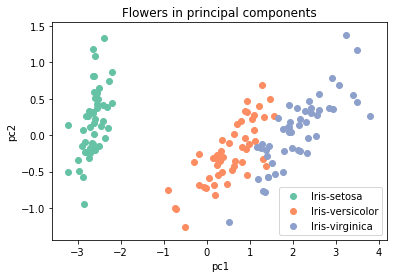

In [6]:
# Honorable mention to PCA
pca = decomposition.PCA(n_components=2)

comps = pca.fit_transform(data)

fig3,ax3 = pyplot.subplots(1,1)

for k,v in ec.items():
    ax3.scatter(comps[v,0], comps[v,1], color=[palette_map[k]], label=k)
    
ax3.legend()
ax3.set_xlabel('pc1')
ax3.set_ylabel('pc2')
ax3.set_title('Flowers in principal components')

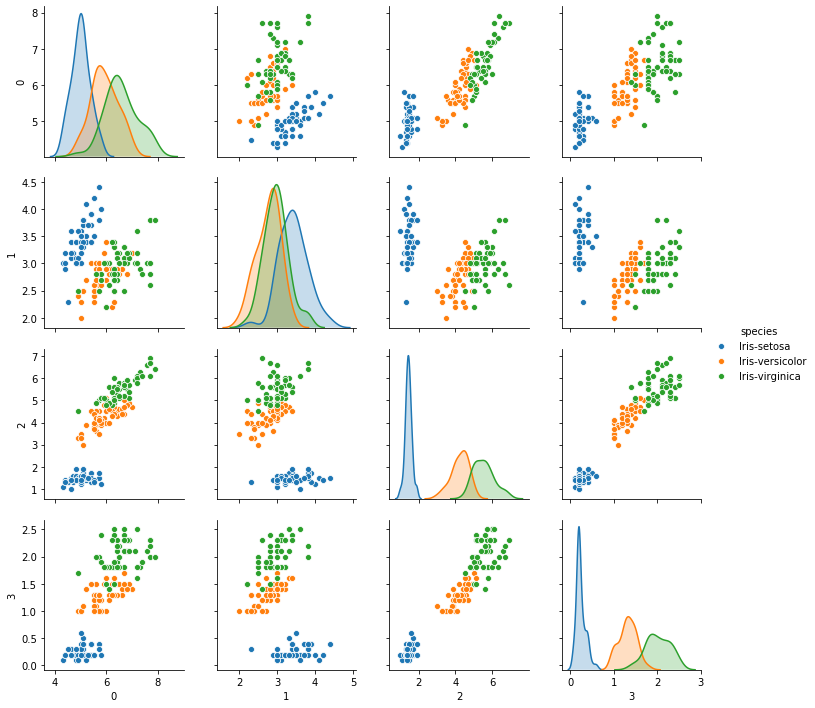

In [7]:
# Honorable mention to Seaborn. Convenient use requires making a dataframe.
import seaborn

df = pandas.DataFrame(data)
df['species'] = labels

seaborn.pairplot(df, hue='species')

In [8]:
# OK - let's get to classification. Want to focus on *binary* classification.
#
# Ignore the Iris-setosa group, since that's separated from the others.
# How can we do well in distinguishing the others?
#

idx = list( ec['Iris-versicolor'] ) + list( ec['Iris-virginica'] )

data2 = data[idx]
labels2 = labels[idx]
ec2 = {flower:np.where(labels2==flower)[0] for flower in np.unique(labels2)}

Support Vector Classifier finds a linear function 0.28x + 1.70y + -4.17 does best to separate the data.


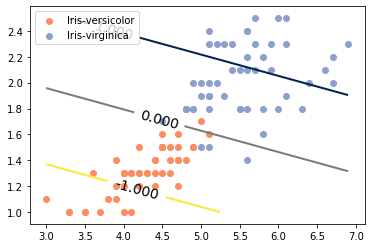

In [9]:
# Binary classification boils down to the following:
# 1. Attach the number -1 to one class, and +1 to the other class. (0 and 1 is another common choice). 
# 2. Try to find a function which takes in numerical values and gives back -1 for data from the first class, 
#    and +1 from the second class.
#
# The art of data science is identifying the right kind of function to use, 
# and the appropriate technique(s) to tease out a meaningful relationship.
#
# The first way to understand this is with a line. 
# The sklearn LinearSVC is one tool for this. Asking it to ".fit(data,labels)"
# is to find the coefficients for my line which do the best at this task.
#

attrs = [2,3]
svc = svm.LinearSVC()
svc.fit(data2[:,attrs], labels2)
print('Support Vector Classifier finds a linear function %.2fx + %.2fy + %.2f does best to separate the data.'%(svc.coef_[0][0], svc.coef_[0][1], svc.intercept_))

fig4,ax4 = pyplot.subplots(1,1)
for k,v in ec2.items():
    ax4.scatter(data2[v,attrs[0]], data2[v,attrs[1]], color=[palette_map[k]], label=k)
    
# plot the line.. a little wizardry is needed.
x,y = data2[:,attrs[0]], data2[:,attrs[1]]
xx,yy = np.meshgrid(
    np.linspace(x.min(), x.max(), 41),
    np.linspace(y.min(), y.max(), 41)
)

L = svc.coef_[0][0]*xx + svc.coef_[0][1]*yy + svc.intercept_
cs = ax4.contour(xx,yy,L, [-1,0,1], cmap=pyplot.cm.cividis_r, linewidths=2)
ax4.clabel(cs, [-1,0,1], fontsize=14, colors='k')

ax4.legend()

In [10]:
# In reality, machine learning is often about asking the model to predict things it
# hasn't "seen before." The notion of "training set" and "testing set" are based on this idea.
# You withold some of your data during the "training" (i.e., the ".fit()") and then ask how it 
# does in predicting afterward.
n = len(data2)
order = np.random.permutation(n)

# fit using roughly half of the data, randomized.
data_tr, data_te = data2[order[:n//2]], data2[order[n//2:]]
labels_tr, labels_te = labels2[order[:n//2]], labels2[order[n//2:]]

svc.fit(data_tr, labels_tr)

# Evaluate performance by asking it to predict on data from the testing set.
prediction = svc.predict(data_te)

train_prediction = svc.predict(data_tr)

print('Actual flower: ', labels_te[:4])
print('Predicted:     ', prediction[:4])

print('')

print('Overall training set accuracy: ', sum(train_prediction==labels_tr)/len(labels_tr))
print('Overall test set accuracy: ', sum(prediction==labels_te)/len(labels_te))

Actual flower:  ['Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-virginica']
Predicted:      ['Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-virginica']

Overall training set accuracy:  0.96
Overall test set accuracy:  0.98


In [11]:
# Two final notes --
# 
# 1. sklearn classifiers can handle more than two classes without effort
# 2. The idea of a linear separator, in particular looking at the coefficients, is the theme of the next part.
#
n_all = len(data)
order = np.random.permutation(n_all)

# fit using roughly half of the data, randomized.
data_tr, data_te = data[order[:n//2]], data[order[n//2:]]
labels_tr, labels_te = labels[order[:n//2]], labels[order[n//2:]]

svc.fit(data_tr, labels_tr)

# Evaluate performance by asking it to predict on data from the testing set.
prediction = svc.predict(data_te)

train_prediction = svc.predict(data_tr)

print('Actual flower: ', labels_te[:4])
print('Predicted:     ', prediction[:4])

print('')

print('Overall training set accuracy: ', sum(train_prediction==labels_tr)/len(labels_tr))
print('Overall test set accuracy: ', sum(prediction==labels_te)/len(labels_te))

Actual flower:  ['Iris-virginica' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica']
Predicted:      ['Iris-virginica' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica']

Overall training set accuracy:  0.94
Overall test set accuracy:  0.99


In [12]:
print('Linear model for distinguishing second and third flowers:')
for j,e in enumerate( svc.coef_[2] ):
    print('%.2f*x%i + '%(e,j), end='')
print('%.2f'%svc.intercept_[2])

Linear model for distinguishing second and third flowers:
-0.57*x0 + -1.22*x1 + 1.13*x2 + 1.45*x3 + -0.89
